# テキストマイニング: Twitter

## 1. はじめに
### 1.1. 本日のゴール

**「テキストって数字みたいに分析できるのか。」**と一瞬でも感じること。

### 1.2. テキストマイニングとは？

- テキスト（文字）を定量的に分析する手法。具体的には、
 - 形態素解析: テキストを単語レベルに分割する
 - wordcloud: 単語の出現頻度を可視化する
 - 共起ネットワーク: 単語間の繋がりを可視化する
 - word2vec(自然言語処理): 深層学習モデルにテキストデータを入力出来るようにする
- ユーザーのレビューデータやSNSの投稿、アンケートの自由記述欄が主な対象
 - レビューデータやSNSの投稿はWebスクレイピングやAPIを使えば簡単に取得できる 

### 1.3. ハンズオンのお題

- みなさんはECサイトでスキーウェアを販売するB社の売り上げ向上プロジェクトにアサインされました。
- 先方は特に子供向けのスキーウェアの売り上げがイマイチ伸びないことを問題視しています。
- みなさんの中で議論をした結果、CVRが低いことから商品をうまく訴求出来ていないことが1つの仮説として浮かんできました。
- そこで、B社子供向けのスキーウェアを購入したユーザーのレビューを収集し、テキストマイニングでユーザーの声を定量的に評価することにしました。

### 1.4. ハンズオンの構成

2. **[データの前処理](#first-bullet)**
3. **[形態素解析](#second-bullet)**
4. **[テキストの出現頻度の可視化; Wordcloud](#third-bullet)**
5. **[テキストの繋がり; 共起ネットワーク](#fourth-bullet)**
6. **[おわりに](#final-bullet)**
 1. 案件事例 by 難波くん

## 2. データの前処理<a class="anchor" id="first-bullet"></a>
### 2.1. 読み込み

In [126]:
import pandas as pd

In [127]:
df_high = pd.read_csv("rakuten_review_high.csv", header = None)
df_high.head()

,0
0,身長107センチ、体重18キロ、5歳の男児用に120センチを購入したところ、ママ！大人のが届...
1,安く買えて良かったです。\n身長140センチで150サイズ買いましたが、裾の調整で問題なさそ...
2,143センチの息子に150を購入。少し大き目でしたがベルト部分や袖の長さを調節できたので問題...
3,色、柄とも豊富で、どれもステキです。\n145cmですが150cmのサイズで\n大きいかな…...
4,注文してからすぐに届きました！\n商品もかっこ良くて気に入りました！\nまだ実際に使用してい...


In [128]:
# 特定の文字を抜く
df_high[0] = df_high[0].str.replace('\n', '')
df_high.head()

,0
0,身長107センチ、体重18キロ、5歳の男児用に120センチを購入したところ、ママ！大人のが届...
1,安く買えて良かったです。身長140センチで150サイズ買いましたが、裾の調整で問題なさそうです。
2,143センチの息子に150を購入。少し大き目でしたがベルト部分や袖の長さを調節できたので問題...
3,色、柄とも豊富で、どれもステキです。145cmですが150cmのサイズで大きいかな…って感じ...
4,注文してからすぐに届きました！商品もかっこ良くて気に入りました！まだ実際に使用していないので...


## 3. 形態素解析<a class="anchor" id="second-bullet"></a>

- 形態素解析とは、「」
- 形態素解析のライブラリとして、Mecabやjanomeがあります。
 - Mecabの方が新しい単語にも対応している。（「インスタ映え」とか。）その一方で、設定が少しめんどくさい。
 - 今回はjanomeを使ってみます。
- 参考資料
 - [janomeの基本的な使い方](https://note.nkmk.me/python-janome-tutorial/)

### 3.1. janomeの基本的な使い方

In [5]:
from janome.tokenizer import Tokenizer

#### 3.1.1. 単語に分割

In [6]:
t = Tokenizer()
text = '本日はデータサイエンス×マーケティング勉強会に参加していただき、ありがとうございます。'
result = t.tokenize(text)

In [7]:
result

<generator object Tokenizer.__tokenize_stream at 0x11e456200>

In [8]:
for token in result:
    print(token)

本日	名詞,副詞可能,*,*,*,*,本日,ホンジツ,ホンジツ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
データ	名詞,一般,*,*,*,*,データ,データ,データ
サイエンス	名詞,一般,*,*,*,*,サイエンス,サイエンス,サイエンス
×	記号,一般,*,*,*,*,×,カケル,カケル
マーケティング	名詞,一般,*,*,*,*,マーケティング,マーケティング,マーケティング
勉強	名詞,サ変接続,*,*,*,*,勉強,ベンキョウ,ベンキョー
会	名詞,接尾,一般,*,*,*,会,カイ,カイ
に	助詞,格助詞,一般,*,*,*,に,ニ,ニ
参加	名詞,サ変接続,*,*,*,*,参加,サンカ,サンカ
し	動詞,自立,*,*,サ変・スル,連用形,する,シ,シ
て	助詞,接続助詞,*,*,*,*,て,テ,テ
いただき	動詞,非自立,*,*,五段・カ行イ音便,連用形,いただく,イタダキ,イタダキ
、	記号,読点,*,*,*,*,、,、,、
ありがとう	感動詞,*,*,*,*,*,ありがとう,アリガトウ,アリガトー
ござい	助動詞,*,*,*,五段・ラ行特殊,連用形,ござる,ゴザイ,ゴザイ
ます	助動詞,*,*,*,特殊・マス,基本形,ます,マス,マス
。	記号,句点,*,*,*,*,。,。,。


In [9]:
t = Tokenizer()
text = '本日はデータサイエンス×マーケティング勉強会に参加していただき、ありがとうございます。'
result = t.tokenize(text)

list(result)

これら`<janome.tokenizer.Token at ...>`に分割した単語の情報が格納されている。それぞれに関してみていくために、for構文で`print()`させていた。

#### 3.1.2. 表層型と基本形

In [12]:
t = Tokenizer()
text = '本日はデータサイエンス×マーケティング勉強会に参加していただき、ありがとうございます。'
result = t.tokenize(text)

print("表層形"+ "|" +"基本形")
print("==================================")
print("\n")

for token in result:
    print(token.surface + "|" + token.base_form)

表層形|基本形


本日|本日
は|は
データ|データ
サイエンス|サイエンス
×|×
マーケティング|マーケティング
勉強|勉強
会|会
に|に
参加|参加
し|する
て|て
いただき|いただく
、|、
ありがとう|ありがとう
ござい|ござる
ます|ます
。|。


#### 3.1.3. 特定の品詞の文字列を抽出する

In [13]:
t = Tokenizer()
text = '本日は'
result = t.tokenize(text)
for token in result:
    #品詞を抽出
    pos = token.part_of_speech.split(',')

In [14]:
pos

['助詞', '係助詞', '*', '*']

In [15]:
t = Tokenizer()
text = '本日はデータサイエンス×マーケティング勉強会に参加していただき、ありがとうございます。'
result = t.tokenize(text)

words = []

for token in result:
    #品詞から名詞だけ抽出
    pos = token.part_of_speech.split(',')[0]
    
    if pos == '名詞':
        words.append(token.base_form)

In [16]:
words

['本日', 'データ', 'サイエンス', 'マーケティング', '勉強', '会', '参加']

### 3.2. レビューデータを形態素解析にかけてみる

In [66]:
list_high = df_high[0].values.tolist()

In [ ]:
list_test = ','.join(list_high)

In [ ]:
t = Tokenizer()
text = list_test
result = t.tokenize(text)

words = []

for token in result:
    #品詞から名詞だけ抽出
    pos = token.part_of_speech.split(',')[0]
    
    if pos == '名詞':
        words.append(token.base_form)

## 4. テキストの出現頻度の可視化; Wordcloud<a class="anchor" id="third-bullet"></a>
### 4.1. word cloud の基本

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [43]:
# リストを文字列に変換
word_chain = ' '.join(words)

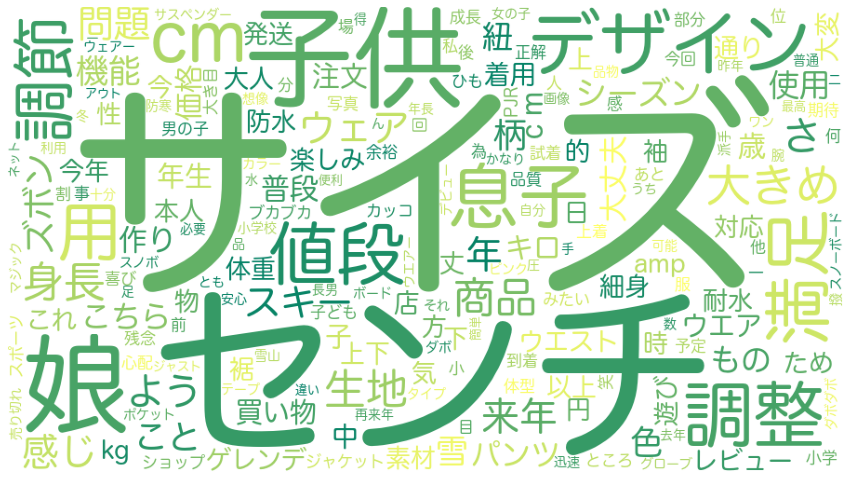

In [44]:
stop_word = [u'の', u'購入', u'そう', u'良い']

# ワードクラウド作成
W_123 = WordCloud(width = 900, height = 500, background_color='white', colormap='summer', collocations=False,font_path='/System/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', stopwords=set(stop_word)).generate(word_chain)

plt.figure(figsize=(15,12))
plt.imshow(W_123)
plt.axis('off')
plt.show()

### 4.2. より深く分析していく

ここまでの処理を関数にします

- list_series: inputになるデータ,listの形でないとエラーでます。
- part_of_speech: 抽出したい品詞を指定します。
- stop_words: word_cloudで省きたい言葉を指定します。

In [53]:
def make_word_cloud(list_series, part_of_speech, stop_words):
    
    # split 
    t = Tokenizer()
    text = list_series
    result = t.tokenize(text)
    words = []
    
    if part_of_speech == "all":
        for token in result:
            words.append(token.base_form)
    
    else:
        for token in result:
            pos = token.part_of_speech.split(',')[0]
            
            if pos in part_of_speech:
                words.append(token.base_form)
    
    # make word cloud
    word_chain = ' '.join(words)
    
    W_123 = WordCloud(width = 900, height = 500, background_color='white', colormap='summer', 
                      collocations=False,font_path='/System/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', 
                      stopwords=set(stop_words)).generate(word_chain)
    
    plt.figure(figsize=(15,12))
    plt.imshow(W_123)
    plt.axis('off')
    return(plt.show())

関数の挙動をチェック

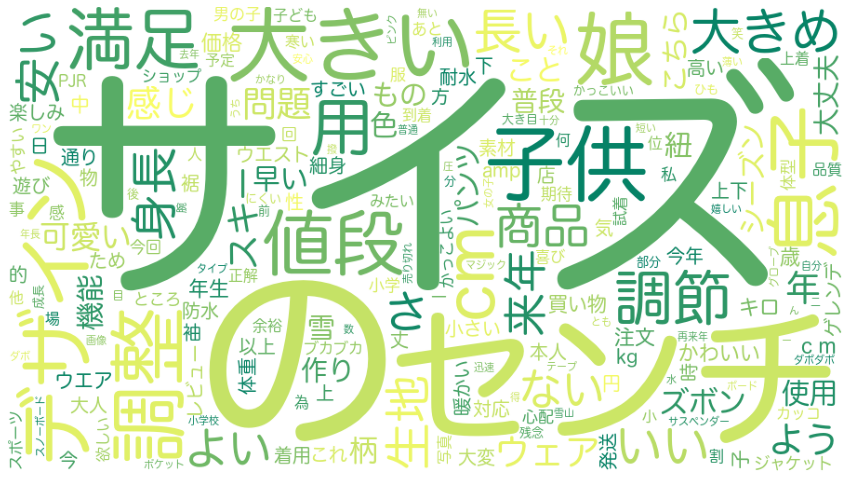

In [52]:
# 引数
list_series = df_high[0].values.tolist()
list_series = ','.join(list_series)
part_of_speech_test = ["名詞", "形容詞"]
stop_words_test = [ u'購入', u'そう', u'良い']

make_word_cloud(list_series, part_of_speech_test, stop_words_test)

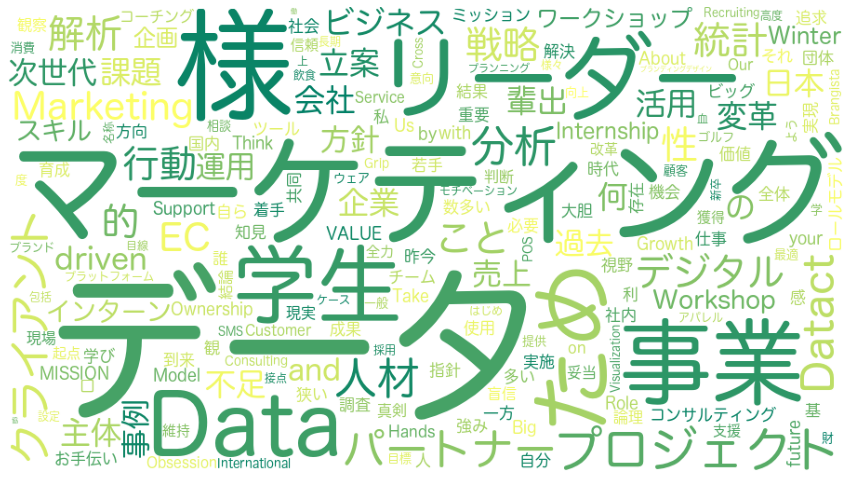

In [65]:
# DatactのHPのテキスト
list_series = "Growth with Data Marketing Support your future driven by data. About Us Datactは学生主体のマーケティングコンサルティング団体です 統計ツールを使用したビッグデータ解析を基に、マーケティング調査・戦略立案を行っています MISSION この会社は何を成すために 存在しているのか 「日本を変革する人材を輩出する」 デジタルビジネス時代の到来により、データ活用の重要性が叫ばれる昨今。誰もがその必要性を感じる一方で、社内における人材不足や知見不足からその課題感に着手できていない企業様もまだまだ多いと感じております。 Datactはデータ分析やデータマーケティングに強みを持つ若手社会人/学生が主体となり、クライアント様の抱える事業課題をデータ利活用を通じて解決し事業を伸ばすお手伝いをさせて頂くとともに、こうした共同プロジェクトを国内で数多く実施することでデータ人材を増やし、日本を変革する次世代人材の輩出を目指しています。 VALUE ミッションを実現するための 価値観及び行動指針 01 Think Big 狭い視野で考えてしまうと大きな結果を得ることはできません。リーダーは大胆な方針と方向性をつくり、示すことによって成果を導きます。 02 Take Ownership リーダーは自分のチームだけでなく、会社全体のために行動します。リーダーは「それは私の仕事ではありません」とは決して口にしません。 03 Role Model リーダーは常にロールモデルとして自ら学び機会を追求し続けるだけでなく、次世代を育成し、コーチングにも真剣に取り組みます。 04 Data-driven and Hands-on リーダーは常にデータに基いて判断します・ただしデータを盲信するのではなく現場をつぶさに観察し、現実と照らし合わせながら論理的に最も妥当だと思われる結論を導き出します。 05 Customer Obsession リーダーは常にパートナーを起点に考え行動します。パートナーから信頼を獲得し、維持していくために全力を尽くします。 Our Service Datactは統計解析やデータ分析に基づくマーケティング戦略立案、デジタルマーケティング運用を行い、 パートナー様のデジタル改革を支援します 1. Data Marketing Consulting クライアント様の顧客データ、POSデータ、売上データなどのマーケティングデータを統計学的に解析し、データに基づいた最適のマーケティング戦略を提供します。 Datact はクライアント様の意向に添えるように、ビジネス・マーケティング方針について何度もご相談させていただき、目標に向かってパートナーとして共に歩んでいきます。 【過去のプロジェクト事例】Grip International様とのゴルフウェアECでの売上向上プロジェクト、Brangista様との一般消費財 ECプラットフォーム上でのマーケティングプロジェクト。 2. Workshop and Recruiting データ分析、マーケティングといった高度なスキルを持った学生との接点を持ち、クライアント様の長期インターンや新卒採用へつなげるためのワークショップ企画を行います。学生目線で、スキルのある学生にとってモチベーションとなるケース設定を行い、企業様の生データを盛り込んだ血の通ったインターン・ワークショップを企画運用いたします。 【過去のプロジェクト事例】Cross Marketing様 Winter Internship, SMS様 Winter Internship(仮名称), Data Visualization Workshop 飲食事業、アパレルブランド事業、EC事業などをはじめとする様々な事業にて包括的なデータ分析、マーケティングプランニング、ブランディングデザインを協働させて頂いております"
part_of_speech_test = ["名詞", "形容詞"]
stop_words_test = []

make_word_cloud(list_series, part_of_speech_test, stop_words_test)

「サイズ」がよく出てくるみたいです。どういう文脈で「サイズ」が使われているのでしょうか？「サイズ」を含むレビューに関してもう一度wordcloudを作ってみます。

In [54]:
df_high["flag"] = 0

for i in range(len(df_high.index)):
    if "サイズ" in df_high.iloc[i, 0]:
        df_high.iloc[i, 1] = 1

In [55]:
df_high_size = df_high.query('flag == 1')

In [56]:
df_high_size.head()

,0,flag
0,身長107センチ、体重18キロ、5歳の男児用に120センチを購入したところ、ママ！大人のが届...,1
1,安く買えて良かったです。身長140センチで150サイズ買いましたが、裾の調整で問題なさそうです。,1
3,色、柄とも豊富で、どれもステキです。145cmですが150cmのサイズで大きいかな…って感じ...,1
6,レビューを見て、大きめなのは想定していましたが、他社製品と比べると、明らかに2サイズくらい大...,1
10,145ｃｍの子供に150サイズで購入。調整できるヒモもついていたし長く着れそうです。カッコイ...,1


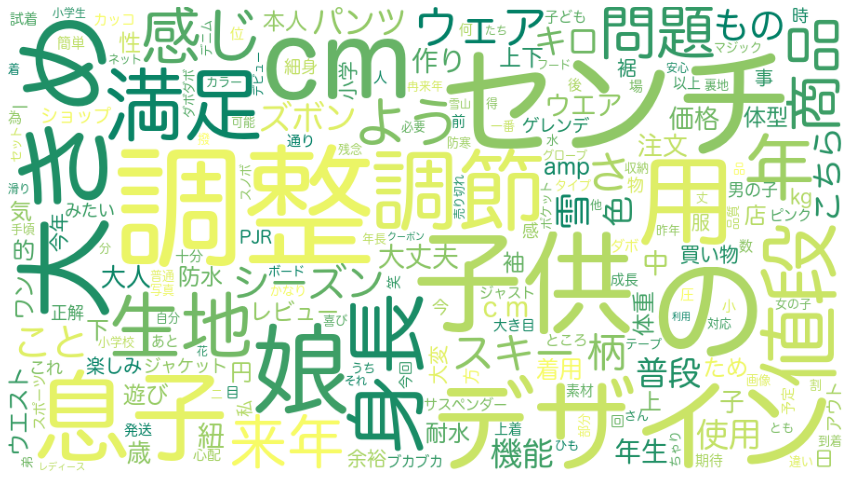

In [64]:
list_series = df_high_size[0].values.tolist()
list_series = ','.join(list_series)
part_of_speech_test = "名詞"
stop_words_test = [ u'購入', u'そう', u'良い', u'サイズ']

make_word_cloud(list_series, part_of_speech_test, stop_words_test)

## 5. テキストの繋がり; 共起ネットワーク<a class="anchor" id="fourth-bullet"></a>

[参考](https://qiita.com/y_itoh/items/7aa33ba0b1e30b3ea33d)

In [129]:
# 数字を抜く, regex=Trueで正規表現を使える
df_high[0] = df_high[0].str.replace(r'\d', '', regex=True)
df_high.head()

,0
0,身長センチ、体重キロ、歳の男児用にセンチを購入したところ、ママ！大人のが届いたよ！というくら...
1,安く買えて良かったです。身長センチでサイズ買いましたが、裾の調整で問題なさそうです。
2,センチの息子にを購入。少し大き目でしたがベルト部分や袖の長さを調節できたので問題なく使用でき...
3,色、柄とも豊富で、どれもステキです。cmですがcmのサイズで大きいかな…って感じですが、簡単...
4,注文してからすぐに届きました！商品もかっこ良くて気に入りました！まだ実際に使用していないので...


In [130]:
list_high = df_high[0].values.tolist()

In [131]:
output = []

for sentence in list_high:
    t = Tokenizer()
    text = sentence
    result = t.tokenize(text)
    
    words = []
    
    for token in result:
        pos = token.part_of_speech.split(',')[0]
        if pos == '名詞':
            words.append(token.base_form)
    
    output.append(words)

In [146]:
import itertools
from collections import Counter

In [147]:
# 文単位の名詞ペアリストを生成
pair_list = [
             list(itertools.combinations(n, 2))
             for n in output if len(output) >=2
             ]

# 名詞ペアリストの平坦化
all_pairs = []
for u in pair_list:
    all_pairs.extend(u)

# 名詞ペアの頻度をカウント
cnt_pairs = Counter(all_pairs)

In [148]:
cnt_pairs

Counter({('身長', 'センチ'): 150,
         ('身長', '体重'): 76,
         ('身長', 'キロ'): 36,
         ('身長', '歳'): 15,
         ('身長', '男児'): 3,
         ('身長', '用'): 54,
         ('身長', '購入'): 241,
         ('身長', 'ところ'): 13,
         ('身長', 'ママ'): 2,
         ('身長', '大人'): 23,
         ('身長', 'の'): 100,
         ('身長', '普段'): 14,
         ('身長', 'ジャスト'): 7,
         ('身長', 'サイズ'): 186,
         ('身長', '服'): 10,
         ('身長', '大きめ'): 70,
         ('身長', '交換'): 3,
         ('身長', 'シーズン'): 37,
         ('身長', '肝心'): 2,
         ('身長', 'ウェア'): 36,
         ('身長', '完全'): 2,
         ('身長', 'デザイン'): 59,
         ('身長', 'カッコ'): 6,
         ('身長', 'ゲレンデ'): 17,
         ('センチ', '体重'): 32,
         ('センチ', 'キロ'): 68,
         ('センチ', '歳'): 16,
         ('センチ', '男児'): 3,
         ('センチ', '用'): 78,
         ('センチ', 'センチ'): 190,
         ('センチ', '購入'): 426,
         ('センチ', 'ところ'): 16,
         ('センチ', 'ママ'): 4,
         ('センチ', '大人'): 37,
         ('センチ', 'の'): 208,
         ('センチ', '普段'): 16,
         

In [150]:
tops = sorted(
    cnt_pairs.items(), 
    key=lambda x: x[1], reverse=True
    )[:50]

In [152]:
import numpy as np

In [153]:
noun_1 = []
noun_2 = []
frequency = []

# データフレームの作成
for n,f in tops:
    noun_1.append(n[0])    
    noun_2.append(n[1])
    frequency.append(f)

df = pd.DataFrame({'前出名詞': noun_1, '後出名詞': noun_2, '出現頻度': frequency})

# 重み付きデータの設定
weighted_edges = np.array(df)

In [154]:
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline 
import japanize_matplotlib

/usr/local/lib/python3.8/site-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


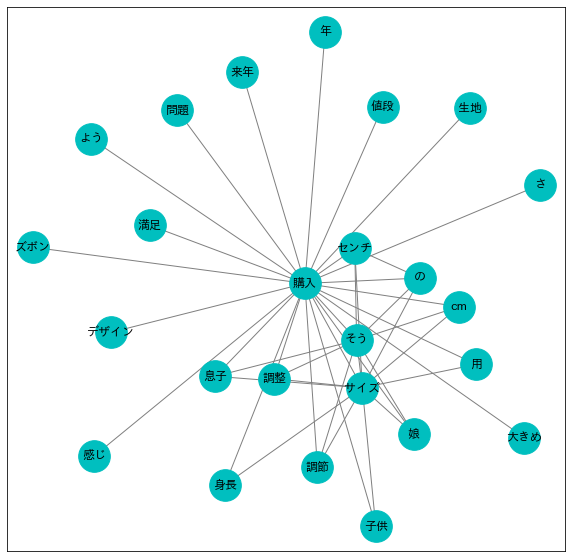

In [160]:
# グラフオブジェクトの生成
G = nx.Graph()

# 重み付きデータの読み込み
G.add_weighted_edges_from(weighted_edges)

# ネットワーク図の描画
plt.figure(figsize=(10,10))
nx.draw_networkx(G,
                 node_color = "c", 
                 node_size = 1000,
                 edge_color = "gray", 
                 font_family = "IPAexGothic") # フォント指定

plt.show()

## 6. おわりに<a class="anchor" id="final-bullet"></a>